In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
!pip install transformers
from transformers import BertTokenizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

import torch
from torch import nn
from transformers import BertModel

from sklearn.metrics import confusion_matrix, classification_report


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 31.5 MB/s 
     |████████████████████████████████| 182 kB 70.9 MB/s 
     |████████████████████████████████| 7.6 MB 66.4 MB/s 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/BERT/IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
df["sentiment"] = df["sentiment"].astype('category')
df["labels"] = df["sentiment"].cat.codes
df = df.drop(columns=['sentiment'])
df

,review,labels
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


Index(['review', 'labels'], dtype='object')
(50000, 2)


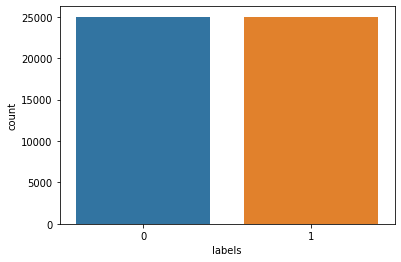

In [ ]:
print(df.columns)
print(df.shape)
sns.countplot(x='labels', data=df);

## Data is balanced

## 1- Preprocessing

In [ ]:
lemmatizer = nltk.stem.WordNetLemmatizer()
word_tokenizer = nltk.tokenize.WhitespaceTokenizer()
def lemmatize_text(text):
  lematized=[]
  for word in word_tokenizer.tokenize(text):
    lematized.append(lemmatizer.lemmatize(word))
  return lematized

In [ ]:
## Lower case 
df['review']=df['review'].apply(lambda x :str.lower(x))
## Remove punc
df['review']=df['review'].str.replace(r'[^\w\s]+', '')
## Stop words
stopword_english = stopwords.words('english')
df["review"] = df.review.apply(lambda x : ' '.join(word for word in x.split() if word not in stopword_english))
df["review"] = df.review.apply(lambda x : x.replace('   ', ' '))
## Lemmatization
df["review"] = df.review.apply(lambda x : lemmatize_text(x))
df['review'] = df.review.apply(lambda x : ' '.join([str(elem) for elem in x]))
df["review"] = df.review.apply(lambda x : x.replace('br', ''))
df

<ipython-input-8-79ed613396a8>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review']=df['review'].str.replace(r'[^\w\s]+', '')


,review,labels
0,one reviewer mentioned watching 1 oz episode y...,1
1,wonderful little production filming techniqu...,1
2,thought wonderful way spend time hot summer we...,1
3,basically there family little boy jake think t...,0
4,petter matteis love time money visually stunni...,1
...,...,...
49995,thought movie right good job wasnt creative or...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,catholic taught parochial elementary school nu...,0
49998,im going disagree previous comment side maltin...,0


In [ ]:
max_words = 512
df['review'] = df.review.apply(lambda x : x[:max_words])
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
      self.labels = list(df.labels)
      self.texts = list(df.review.apply(lambda x :tokenizer(x, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt")))

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_list = []
test_list = []
val_list = []
labels_df = df.groupby('labels')

for i, g in labels_df:
    train, test, val = np.split(g, [int(.7 * len(g)), int(.8 * len(g))])
    #print("========="+str(i)+"=============")
    #print(train)
    train_list.append(train)
    #print(test)
    test_list.append(test)
    #print(val)
    val_list.append(val)

df_train = pd.concat(train_list)
df_val = pd.concat(test_list)
df_test = pd.concat(val_list)

In [ ]:
df_train

,review,labels
10170,know people think movie without even seen typi...,1
23371,ring videotape website problem feardotcom dang...,0
30597,favorite three care bear movie liked song big ...,1
128,movie one best movie seen year didnt see cameo...,1
12868,say exciting talk fashion weird way solve myst...,1
...,...,...
2531,another hitler ever arises thanks part nonsens...,0
26374,typical woman prison movie thought woman sexy ...,0
12365,imagine film complete opposite lawrence arabia...,0
31046,imagine young people involved making necromanc...,0


In [ ]:
df_val

,review,labels
38923,read back dvd case thought sounded really inte...,0
38246,beat exciting movie couple young punk trying s...,1
38538,get go horror movie intelligent cast director ...,1
37632,went see movie always liked kevin costner felt...,1
38306,called other paulie phone said watching hood f...,1
...,...,...
37828,love movie first didnt expect much movie since...,1
37750,inherited x dvd collection left best friend en...,1
38990,happens one favorite horror film rich classy p...,1
37013,agree movie sex without seduction love fact ma...,0


In [ ]:
df_test

,review,labels
43633,heard film released theme felt curious saw big...,0
41116,lost two half hour life never regain again ho...,0
45685,love dog interesting character movie golden re...,1
46951,admit liking lot socalled fratpack movie matte...,0
48190,craig ewer officially writerdirector see film ...,1
...,...,...
45908,nothing weird coincidence decided watch starli...,0
46545,ok plot point might bit obvious interesting id...,1
46272,maybe expected much film least comedy funny on...,0
46778,really spoiler opinion wanted cover neverthele...,0


Text(0.5, 1.0, 'Test')

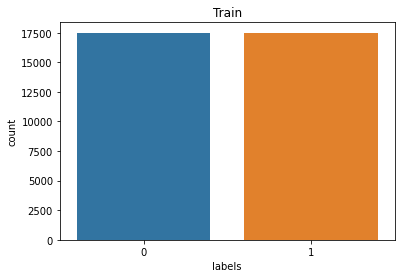

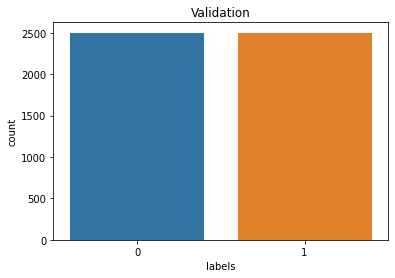

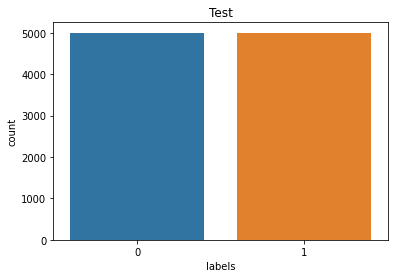

In [ ]:
sns.countplot(x='labels', data=df_train);
plt.title("Train")
plt.figure()
sns.countplot(x='labels', data=df_val);
plt.title("Validation")
plt.figure()
sns.countplot(x='labels', data=df_test);
plt.title("Test")

In [ ]:
print("Train distribution")
print(df_train['labels'].value_counts())
print("Val distribution")
print(df_val['labels'].value_counts())
print("Test distribution")
print(df_test['labels'].value_counts())

Train distribution
1    17500
0    17500
Name: labels, dtype: int64
Val distribution
0    2500
1    2500
Name: labels, dtype: int64
Test distribution
0    5000
1    5000
Name: labels, dtype: int64


## Now we have train , valid and test data with the required proportions and balanced

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout_bert = nn.Dropout(0.5)
        self.dropout = nn.Dropout(0.2)
        self.linear1 = nn.Linear(768, 512)
        self.relu1 = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.linear2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.linear3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(128, 64)
        self.relu4 = nn.ReLU()
        self.linear5 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_id, mask):

        _, x = self.bert(input_ids=input_id, attention_mask=mask,return_dict=False)
        x = self.dropout_bert(x)
        x = self.relu1(self.linear1(x))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.relu2(self.linear2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.relu3(self.linear3(x))
        x = self.relu4(self.linear4(x))
        x = self.sigmoid(self.linear5(x))
        return x

## Training

In [ ]:
def save_checkpoint(state,epoch):
  print("Saving Checkpoint")
  torch.save(state,'/content/gdrive/MyDrive/BERT/e-6/chckpt'+str(epoch)+'.pth.tar')
  print("Save done successfully")

In [ ]:
from torch.optim import Adam
from tqdm import tqdm

def train(model,train_data,val_data,learning_rate,epochs):
  epoch_list = []
  train_loss = []
  val_loss = []
  train_accuracy = []
  val_accuracy = []
  # Early stopping
  the_last_loss = 100
  patience = 10
  trigger_times = 0
  epoch_num=1
  load=True
  loadFrom=30
  train, val = Dataset(train_data), Dataset(val_data)

  train_dataloader = torch.utils.data.DataLoader(train, batch_size=8,shuffle=True)
  val_dataloader = torch.utils.data.DataLoader(val, batch_size=8)

  device = torch.device("cuda")
    

  criterion = nn.BCELoss()
  optimizer = Adam(model.parameters(), lr= learning_rate)
  model = model.cuda()
  criterion = criterion.cuda()

  if load:
    print("Loading checkpoint")
    checkpointt=torch.load('/content/gdrive/MyDrive/BERT/e-6/chckpt'+str(loadFrom)+'.pth.tar')
    model.load_state_dict(checkpointt["state_dict"])
    optimizer.load_state_dict(checkpointt["optimizer"])
    epoch_num=checkpointt['epoch_num']
    epoch_num+=1
    epoch_list = checkpointt['epoch_list']
    train_loss = checkpointt['train_loss']
    val_loss = checkpointt['val_loss']
    train_accuracy = checkpointt['train_accuracy']
    val_accuracy = checkpointt['val_accuracy']
    the_last_loss=checkpointt['the_last_loss']
    trigger_times=checkpointt['trigger_times']
    print("Load done successfully from epoch "+str(loadFrom))
    print("Starting from epoch "+str(epoch_num))

  while epoch_num<=epochs:

          total_acc_train = 0
          total_loss_train = 0

          for train_input, train_label in tqdm(train_dataloader):

              train_label = train_label.to(device)
              mask = train_input['attention_mask'].to(device)
              input_id = train_input['input_ids'].squeeze(1).to(device)
              output = model(input_id, mask)

              batch_loss = criterion(output.squeeze(1), train_label.float())
              total_loss_train += batch_loss.item()

              y_pred_tag = torch.round(output.squeeze(1))
              acc = (y_pred_tag == train_label).sum()

              total_acc_train += acc

              model.zero_grad()
              batch_loss.backward()
              optimizer.step()
          
          total_acc_val = 0
          total_loss_val = 0

          with torch.no_grad():

              for val_input, val_label in val_dataloader:

                  val_label = val_label.to(device)
                  mask = val_input['attention_mask'].to(device)
                  input_id = val_input['input_ids'].squeeze(1).to(device)

                  output = model(input_id, mask)

                  batch_loss = criterion(output.squeeze(1), val_label.float())
                  total_loss_val += batch_loss.item()
                  
                  y_pred_tag = torch.round(output.squeeze(1))
                  acc = (y_pred_tag == val_label).sum()
                  total_acc_val += acc
          
          train_loss.append(total_loss_train / len(train_data))
          train_accuracy.append(total_acc_train.item() / len(train_data))
          val_loss.append(total_loss_val / len(val_data))
          val_accuracy.append(total_acc_val.item() / len(val_data))
          epoch_list.append(epoch_num)

          print(
              f'Epochs: {epoch_num} | Train Loss: {total_loss_train / len(train_data): .3f} \
              | Train Accuracy: {total_acc_train / len(train_data): .3f} \
              | Val Loss: {total_loss_val / len(val_data): .3f} \
              | Val Accuracy: {total_acc_val / len(val_data): .3f}')
          
          # Early stopping
          the_current_loss = total_loss_val / len(val_data)
          if the_current_loss > the_last_loss:
              trigger_times += 1

              if trigger_times >= patience:
                  print('Early stopping!')
                  break

          else:
            trigger_times = 0

          the_last_loss = the_current_loss
          checkpoint={'state_dict':model.state_dict(),'optimizer':optimizer.state_dict(),'epoch_num':epoch_num,'epoch_list':epoch_list,
                      'train_loss':train_loss,'val_loss':val_loss,'train_accuracy':train_accuracy,
                      'val_accuracy':val_accuracy,'the_last_loss':the_last_loss,'trigger_times':trigger_times}
          save_checkpoint(checkpoint,epoch_num)
          epoch_num=epoch_num+1
  return epoch_list,train_loss,val_loss,train_accuracy,val_accuracy

In [ ]:
epochs = 30
model = BertClassifier()
lr = 1e-6
epoch_list = []
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []
epoch_list,train_loss,val_loss,train_accuracy,val_accuracy=train(model, df_train, df_val, lr, epochs)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading checkpoint
Load done successfully from epoch 30
Starting from epoch 31


In [ ]:
val_accuracy

[0.501,
 0.7796,
 0.8284,
 0.8492,
 0.854,
 0.8546,
 0.8546,
 0.8536,
 0.853,
 0.8406,
 0.8554,
 0.8528,
 0.847,
 0.8508,
 0.851,
 0.8514,
 0.853,
 0.855,
 0.8576,
 0.8564,
 0.853,
 0.8558,
 0.8518,
 0.8522,
 0.8424,
 0.85,
 0.8546,
 0.857,
 0.8564,
 0.859]

0.859


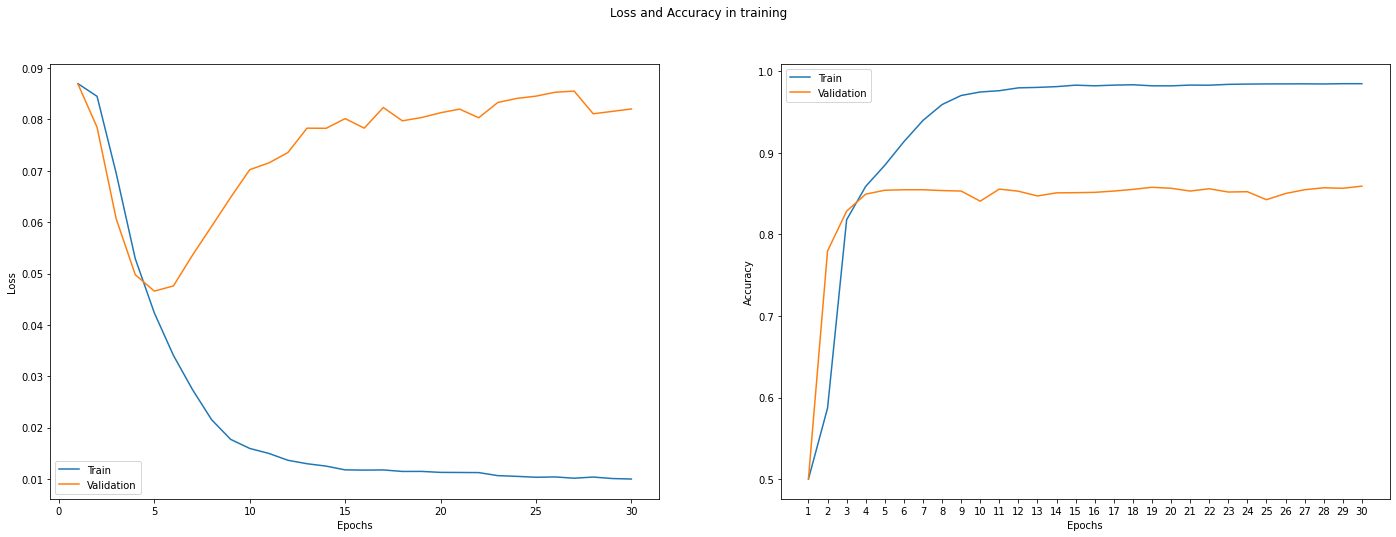

In [ ]:
plt.figure(figsize = [24, 8])
plt.suptitle("Loss and Accuracy in training")
plt.subplot(1,2,1)
plt.plot(epoch_list,train_loss);
plt.plot(epoch_list,val_loss);
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","Validation"])
plt.subplot(1,2,2)
plt.plot(epoch_list,train_accuracy);
plt.plot(epoch_list,val_accuracy);
max_acc=max(val_accuracy)
print(max_acc)
plt.xlabel("Epochs");
plt.ylabel("Accuracy")
plt.xticks(ticks=range(1,31))
plt.legend(["Train","Validation"]);

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=32)

    #use_cuda = torch.cuda.is_available()
    device = torch.device("cuda")
    final_confusion_matrix = np.zeros([2,2])

    model = model.cuda()

    total_acc_test = 0
    
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)
              output = model(input_id, mask)
              y_pred_tag = torch.round(output.squeeze(1))
              acc = (y_pred_tag == test_label).sum()
              total_acc_test += acc
              final_confusion_matrix += confusion_matrix(test_label.cpu().data.numpy(), y_pred_tag.cpu().data.numpy())
    
    TP = final_confusion_matrix[0][0]
    FP = final_confusion_matrix[0][1]
    FN = final_confusion_matrix[1][0]
    TN = final_confusion_matrix[1][1]
    Percision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    print(f'Percision : {Percision}')
    print(f'Sensitivity (Recall) : {Recall}')
    print(f'Specifity : {TN/(TN+FP)}')
    print(f'F1 Score = {((2*Percision*Recall)/(Percision+Recall))}')
    print('Confusion Matrix :')
    print(final_confusion_matrix)
    
evaluate(model, df_test)

Test Accuracy:  0.861
Percision : 0.8498
Sensitivity (Recall) : 0.8696275071633238
Specifity : 0.8531482205709816
F1 Score = 0.8595994335423832
Confusion Matrix :
[[4249.  751.]
 [ 637. 4363.]]
